<a href="https://colab.research.google.com/github/MiklRov/Yandex_practicum/blob/main/klaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Выпускной проект. 
Кластеризация пользователей мобильного приложения "Ненужные вещи"

### Описание проекта
Дерзкая и амбициозная команда сервиса «Ненужные вещи» жаждет увидеть в своём составе крутого аналитика, который возьмёт огромное количество наших данных и сотворит из них чудо. Конкретнее про чудо: наши пользователи совершают много действий в приложении, и мы уверены, что в этих данных есть инсайты, которые позволят нам стать лучшим приложением для продажи ненужных вещей. В рамках работы необходимо проанализировать поведение пользователей в мобильном приложениии "Ненужные вещи" и сегментировать их на разные группы для того, чтобы наладить более точный механизм взаимодействия с пользователями и повысить вовлеченность групп пользователей с низкими показателями.

### Материалы
- Дашборд - https://public.tableau.com/profile/sokolymba#!/vizhome/YandexPraktikum/sheet2?publish=yes

### План исследования
- Загрузить данные и получить первичное представление о структуре и наполнении.

---

- Исследовать и обработать дубликаты;
- Исследовать и заменить пропущенные значения;
- В тех случаях, где необходимо, привести данные к соответствующим типам;
- Если необходимо, то изменить и привести названия столбцов к нижнему регистру;
- Выделить из столбца с датой необходимые временные промежутки.

---

- Определить, сколько всего пользователей воспользовались приложением;
- Определить, сколько пользователей приносят нам наши источники;
- Построить график распределения событий по дням за исследуемый период;
- Построить график распредления событий по дням с разбивкой по источникам;
- Посчитать конверсию пользователей в целевое событие - просмотр контактов;
- Определить время начала и конца события для каждого пользователя в приложении;
- Сформировать таблицу с признаками, необходимыми для кластеризации;
- Произвести рассчет показателей: продолжительность каждого сеанса пользователя, количество совершения пользователем целевого действия, определить количество просмотров рекомендованных объявлений и добавлений объявления в избранное, посчитать общее время использования приложения для каждого пользователя;
- Построить графики распределения признаков и написать вывод;
- Построить матрицу корреляции признаков и написать вывод;
- На основании получившихся признаков разобить пользователей на группы при помощи ML;
- Построить графики распределения признаков для кластеров и описать получившиеся кластеры.

---

- Проверить гипотезу: Конверсия в просмотр контактов между пользователями, установившими приложение по ссылке из yandex и пользователями, установившими приложение по ссылке из google, различается;
- Проверить гипотезу: Конверсия в добавление объявления в избранное между пользователями, установшими приложение по ссылке из yandex, отличается от конверсии пользователей, установивших приложение по ссылке из google.

---

- Написать общий вывод и подготовить рекомендации для маркетологов по увеличению показателя вовлеченности пользователей в приложение;
- Подготовить презентацию с результатами исследования;
- Подготовить дашборд в Tableau.

### <a id='step1'>Импорт библиотек, данных и получение первичной информации</a>

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import math as mth
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import calendar
from matplotlib import rcParams
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

pd.set_option('display.max_colwidth', 150)
pd.options.display.float_format = '{:,.2f}'.format
plt.style.use('dark_background')
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv', sep = ',')

In [3]:
sources = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_soures.csv', sep = ',')

In [4]:
for df in [data, sources]:
    display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


None

In [5]:
for df in [data, sources]:
    display(df.isna().sum())

event.time    0
event.name    0
user.id       0
dtype: int64

userId    0
source    0
dtype: int64

In [6]:
for df in [data, sources]:
    display(df.duplicated().sum())

0

0

In [7]:
for df in [data, sources]:
    display(df.head())

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


In [8]:
for df in [data, sources]:
    display(df.describe())
    

,event.time,event.name,user.id
count,74197,74197,74197
unique,74197,16,4293
top,2019-10-07 00:00:00.431357,tips_show,cb36854f-570a-41f4-baa8-36680b396370
freq,1,40055,478


,userId,source
count,4293,4293
unique,4293,3
top,020292ab-89bc-4156-9acf-68bc2783f894,yandex
freq,1,1934


## Предобработка данных

Изменим названия столбцов data

In [9]:
data.columns = ['event_time', 'event_name', 'user_id']

In [10]:
data.head()

,event_time,event_name,user_id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


Изменим названия столбцов sources

In [11]:
sources.columns = ['user_id', 'source']

In [12]:
sources.head()

,user_id,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


Приведем столбец event_time датасета data к формату даты и округлим данные до 1 секунды

In [13]:
data['event_time'] = pd.to_datetime(data['event_time'], format='%Y.%m.%d %H:%M:%S').dt.round('1S')

In [14]:
data.head()

,event_time,event_name,user_id
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


Проверим количество пользователей в data

In [15]:
len(data['user_id'].unique())

4293

Проверим количество пользователей в sources

In [16]:
len(sources['user_id'].unique())

4293

In [17]:
set(sources['user_id']) == set(data['user_id'])

True

Количество пользователей в обоих датасетах совпадает, можно склеить их в один.

In [18]:
df = data.merge(sources, on='user_id', how = 'right')

In [19]:
df.sample(5)

,event_time,event_name,user_id,source
34121,2019-10-23 12:08:27,photos_show,9f9034e9-966d-4052-b3ab-5389f9585eb3,yandex
48363,2019-10-22 11:33:04,favorites_add,8192183e-3d08-48e4-b975-f9f0ede5e919,google
37438,2019-10-19 14:53:25,tips_show,c390142d-654a-40bb-855b-2a4b3bd63040,google
1809,2019-10-07 12:02:19,contacts_show,ef8580c3-d3a1-4fe4-91a9-60086d5e1f84,google
64870,2019-10-28 20:45:20,photos_show,2ac7795b-88dc-47ea-8086-aa1facdfc701,yandex


Выделим из столбцов с датоами час, неделю, месяц, год и полную дату в отдельные столбцы

In [20]:
df['event_hour'] = df['event_time'].dt.hour
df['event_week'] = df['event_time'].astype('datetime64[W]')
df['event_month'] = df['event_time'].astype('datetime64[M]')
df['event_year'] = df['event_time'].astype('datetime64[Y]')
df['event_date'] = df['event_time'].astype('datetime64[D]')

In [21]:
df.sample(10)

,event_time,event_name,user_id,source,event_hour,event_week,event_month,event_year,event_date
5903,2019-10-08 10:15:15,tips_show,65d10296-3cf9-4544-9179-24b7f3aa80df,yandex,10,2019-10-03,2019-10-01,2019-01-01,2019-10-08
19998,2019-10-12 15:46:41,tips_show,c211e58f-c5da-4672-98b7-837a060dfd0d,yandex,15,2019-10-10,2019-10-01,2019-01-01,2019-10-12
68566,2019-11-01 17:59:44,favorites_add,90fc4434-20b6-467b-9f76-28fa2f9a0140,yandex,17,2019-10-31,2019-11-01,2019-01-01,2019-11-01
14035,2019-10-10 15:44:05,tips_show,7b19385d-261c-4e1c-9a3a-66aac1067e0c,yandex,15,2019-10-10,2019-10-01,2019-01-01,2019-10-10
7216,2019-10-08 12:42:52,search_6,c5fdea32-0381-480d-b572-8d89ecc7bce2,other,12,2019-10-03,2019-10-01,2019-01-01,2019-10-08
53196,2019-10-31 14:13:26,tips_show,6c68d38e-14a0-4b9a-ab9d-7bd38367beed,yandex,14,2019-10-31,2019-10-01,2019-01-01,2019-10-31
49735,2019-10-26 13:27:04,contacts_show,e387d029-59eb-41b9-9be5-5548389c079c,google,13,2019-10-24,2019-10-01,2019-01-01,2019-10-26
8321,2019-10-08 21:37:41,photos_show,1a7e535b-188c-4015-bf80-5235757be75c,google,21,2019-10-03,2019-10-01,2019-01-01,2019-10-08
60473,2019-10-26 22:45:07,tips_show,54c44f9d-44af-4d2b-8e3c-364df92040fb,google,22,2019-10-24,2019-10-01,2019-01-01,2019-10-26
34953,2019-10-22 15:07:48,photos_show,dd050258-ee33-4fe7-bfa8-777c6d010162,other,15,2019-10-17,2019-10-01,2019-01-01,2019-10-22


Посмотрим, что в столбцах event_name и source

In [22]:
df['source'].value_counts()

yandex    34286
google    20445
other     19466
Name: source, dtype: int64

In [23]:
df['event_name'].value_counts()

tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4450
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
show_contacts       79
Name: event_name, dtype: int64

Так как события contacts_show и show_contacts обозначают одно и то же событие - пользователь нажал на кнопку "Показать номер телефона", то можно склеить их в одно. Аналогично можно поступить с событиями search, т.к в нашем исследовании неважно, что именно ищут пользователи.

In [24]:
def events_type(i):
    if i == 'show_contacts':
        new_name = 'contacts_show'
        return new_name
    elif 'search' in i:
        new_name = 'search'
        return new_name
    return i

df['event_name'] = df['event_name'].apply(events_type)

In [25]:
df['event_name'].value_counts()

tips_show        40055
photos_show      10012
search            6784
advert_open       6164
contacts_show     4529
map               3881
favorites_add     1417
tips_click         814
contacts_call      541
Name: event_name, dtype: int64

In [26]:
df.head()

,event_time,event_name,user_id,source,event_hour,event_week,event_month,event_year,event_date
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,0,2019-10-03,2019-10-01,2019-01-01,2019-10-07
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,0,2019-10-03,2019-10-01,2019-01-01,2019-10-07
2,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,0,2019-10-03,2019-10-01,2019-01-01,2019-10-07
3,2019-10-07 00:01:28,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,0,2019-10-03,2019-10-01,2019-01-01,2019-10-07
4,2019-10-07 00:01:35,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,0,2019-10-03,2019-10-01,2019-01-01,2019-10-07


## EDA

### Исследуем выбросы

Посмотрим количество действий на пользователя, что бы устранить "гиперактивных"

In [27]:
user_events = df.pivot_table(index='user_id', aggfunc={'event_name':'count'})
user_events.columns = ['event_count']
display('Минимум событий на одного пользователя:', user_events['event_count'].min())
display('Максимум событий на одного пользователя:', user_events['event_count'].max())

'Минимум событий на одного пользователя:'

1

'Максимум событий на одного пользователя:'

478

In [28]:
user_events.describe()

,event_count
count,"4,293.00"
mean,17.28
std,29.13
min,1.00
25%,5.00
50%,9.00
75%,17.00
max,478.00


Посмотрим на боксплоте

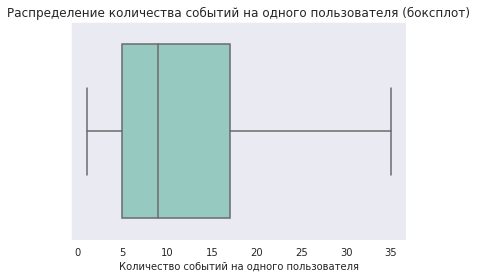

In [29]:
sns.boxplot(user_events['event_count'], showfliers=False)
plt.title('Распределение количества событий на одного пользователя (боксплот)')
plt.xlabel('Количество событий на одного пользователя')
plt.ylabel('')
plt.show();

Посмотрим границы выбросов

In [30]:
def my_per(df, column):
    five = np.percentile(df[column], [95])[0]
    one = np.percentile(df[column], [99])[0]
    display(f'Не более 5% данных больше значения {five}')
    display(f'Не более 1% данных больше значения {one}')

In [31]:
my_per(user_events, 'event_count')

'Не более 5% данных больше значения 59.0'

'Не более 1% данных больше значения 132.0'

Обрежем по 99 процентиль

In [32]:
right_cut = user_events.event_count.quantile(0.99)
user_filtered = user_events.query('event_count <= @right_cut')

In [33]:
user_filtered.describe()

,event_count
count,"4,251.00"
mean,15.19
std,17.78
min,1.00
25%,5.00
50%,9.00
75%,17.00
max,132.00


In [34]:
display(f'Разница между количеством пользователей {user_events["event_count"].count() - user_filtered["event_count"].count()}')
display(f'% потери {(user_events["event_count"].count() - user_filtered["event_count"].count())/ user_events["event_count"].count() * 100:.2f} %')
display('Количество событий на одного пользователя:')
display(f'Среднее по исходным данным: {user_events["event_count"].mean():.2f}. Среднее по очищенным данным: {user_filtered["event_count"].mean():.2f}')
display(f'Медиана по исходным данным: {user_events["event_count"].median():.2f}. медиана по очищенным данным: {user_filtered["event_count"].median():.2f}')

'Разница между количеством пользователей 42'

'% потери 0.98 %'

'Количество событий на одного пользователя:'

'Среднее по исходным данным: 17.28. Среднее по очищенным данным: 15.19'

'Медиана по исходным данным: 9.00. медиана по очищенным данным: 9.00'

In [35]:
clear_user = user_events[user_events['event_count'] < 132].index
df_clean = df[df['user_id'].isin(clear_user)].copy()

### Распределение по пользователям

Построим график распределения количества событий на пользователя

In [36]:
user_events = df_clean.pivot_table(index='user_id', aggfunc={'event_name':'count'})

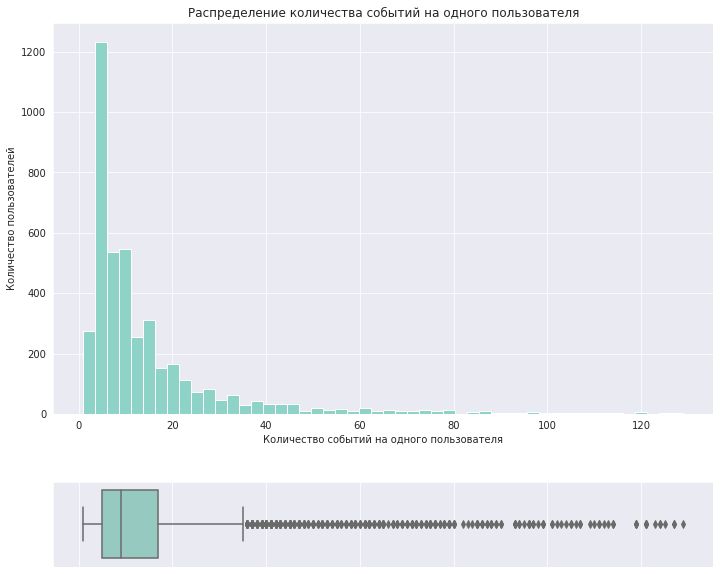

In [37]:

fig = plt.figure(figsize=(16, 10))
grid = plt.GridSpec(4, 4, hspace=0.8)

ax_main = fig.add_subplot(grid[:-1, :-1])
plt.grid(True)

ax_bottom = fig.add_subplot(grid[-1, 0:-1], xticklabels=[])
plt.grid(True)


ax_main.hist(user_events['event_name'], bins=50)


sns.boxplot(user_events['event_name'], ax=ax_bottom, orient='h')
ax_bottom.set(xlabel='')

ax_main.set(title='Распределение количества событий на одного пользователя',\
            xlabel='Количество событий на одного пользователя',\
            ylabel='Количество пользователей')

plt.show();

### Распределение пользователей, пришедших из каждого источников

In [38]:
source = df_clean.groupby('source').agg({'user_id' : 'nunique'})
source.columns = ['count_unique_user']
source['pct_unique_user'] = round(source['count_unique_user'] / source['count_unique_user'].sum(),4)*100
source.sort_values(by='pct_unique_user', ascending=False)

,count_unique_user,pct_unique_user
source,,
yandex,1911,44.98
other,1219,28.69
google,1119,26.34


#### Посчитаем, сколько раз было совершено каждое действие

In [39]:
df_clean.groupby('event_name').agg({'user_id' : 'count'}).sort_values(by='user_id', ascending=False)

,user_id
event_name,
tips_show,34148
photos_show,9368
search,6442
advert_open,4973
contacts_show,3652
map,3233
favorites_add,1222
tips_click,719
contacts_call,537


### Пользователи в разрезе дат, дней недели

Посмотрим, за какой период у нас есть данные

In [40]:
display(f'В логе представлены события за период с {df_clean["event_date"].min().date()} по {df_clean["event_date"].max().date()}')

'В логе представлены события за период с 2019-10-07 по 2019-11-03'

Посчитаем количество событий по дням для каждого пользователя

In [41]:
df_clean['week_day'] = df_clean['event_date'].apply(lambda x: calendar.day_name[x.weekday()])

In [42]:
events_by_day = df_clean.groupby(['event_date','week_day'], as_index=False).agg({'user_id':'count'})

In [43]:
events_by_day.sort_values(by='user_id', ascending=False)

,event_date,week_day,user_id
16,2019-10-23,Wednesday,3056
21,2019-10-28,Monday,2726
22,2019-10-29,Tuesday,2690
17,2019-10-24,Thursday,2684
7,2019-10-14,Monday,2615
20,2019-10-27,Sunday,2583
27,2019-11-03,Sunday,2546
24,2019-10-31,Thursday,2540
14,2019-10-21,Monday,2516
19,2019-10-26,Saturday,2504


In [44]:
events_by_day['user_id'].mean()

2296.214285714286

Построим график распределения событий по дням

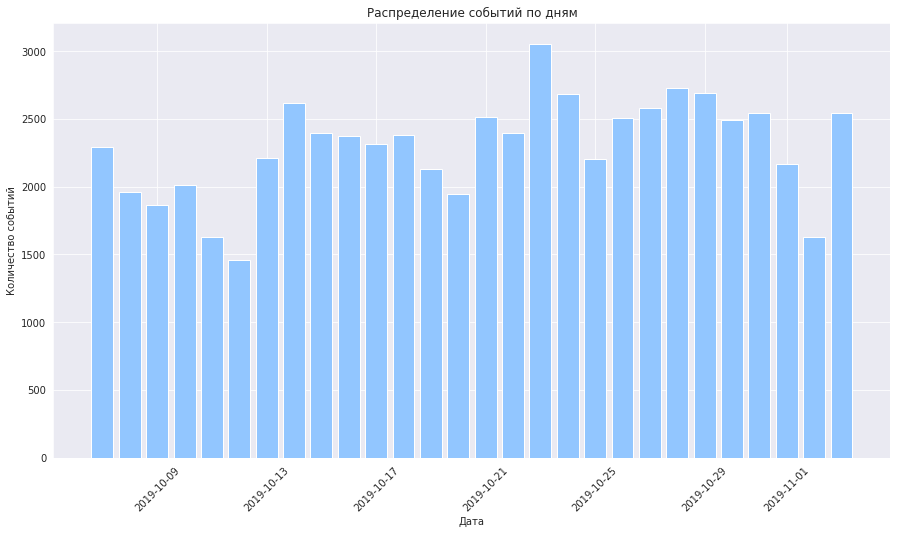

In [45]:
plt.figure(figsize=(15, 8))
with plt.style.context('seaborn-pastel'):
    plt.bar(events_by_day['event_date'], events_by_day['user_id'])
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.title('Распределение событий по дням')
#avg = events_by_day['user_id'].mean()
#ax = avg.plot(kind='line', subplots=True, layout=(1,8), figsize=(40,8), 
#         sharey=True, title="Average movement")

plt.xticks(rotation=45)
plt.grid(True)
plt.show();

Посмотрим по дням недели

In [46]:
week_events = df_clean.groupby('week_day', as_index=False).agg({'event_time':'count'}).sort_values(by='event_time', ascending=False)

week_events

,week_day,event_time
1,Monday,10146
6,Wednesday,9786
4,Thursday,9545
5,Tuesday,9436
3,Sunday,9286
0,Friday,8380
2,Saturday,7715


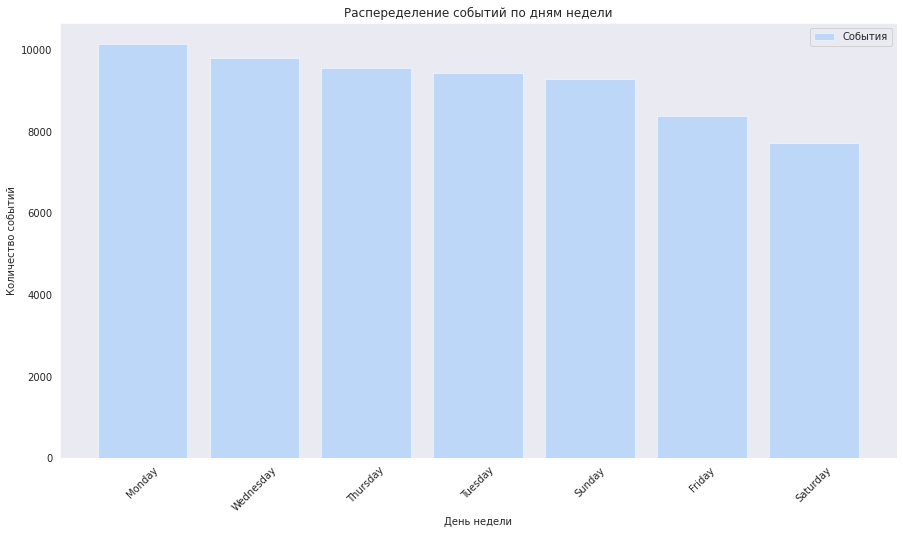

In [47]:
plt.figure(figsize=(15, 8))
with plt.style.context('seaborn-pastel'):
    plt.bar(week_events['week_day'], week_events['event_time'], alpha=.5)
plt.title('Распеределение событий по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество событий')
plt.legend(['События'])
plt.xticks(rotation=45)
plt.show();

### Промежуточный вывод

- Нам доступны данные за период с 07.10.2019 по 03.11.2019;
- 4 полноценные недели: 1 неделя - с 07.10.2019 по 12.10.2019, 2 неделя - с 13.10.2019 по 20.10.2019, 3 неделя - с 21.10.2019 по 27.10.2019, 4 неделя - с 28.10.2019 по 03.11.2019; 
- Больше всего событий совершено 23.10.2019 - 3056;
- Меньше всего событий совершено 12.10.2019 - 1455;
- Наименьшее количество событий и самые заметные просадки происходят в выходные дни - 12.10.2019 и 02.11.2019 - оба эти дня приходятся на субботу. Однако стоит отметить, что в последние выходные дни октября активность больше, чем в остальные выходные. ЗП/аванс начиная с 22го числа?
- Больше всего событий происходит по понедельникам;
- Меньше всего событий происходит по субботам;
- В целом, данные распределены равномерно. Нет аномалий.

### Посмотрим по источникам

In [48]:
df.groupby(['source'],as_index=False).agg({'user_id':'count'})

,source,user_id
0,google,20445
1,other,19466
2,yandex,34286


Разнесем источники по разным датасетам

In [49]:
yandex = df_clean.query('source == "yandex"')\
.groupby('event_date', as_index=False).agg({'user_id':'count'})

google = df_clean.query('source == "google"')\
.groupby('event_date', as_index=False).agg({'user_id':'count'})

other = df_clean.query('source == "other"')\
.groupby('event_date', as_index=False).agg({'user_id':'count'})

Построим график распределения количества событий по дням для каждого источника

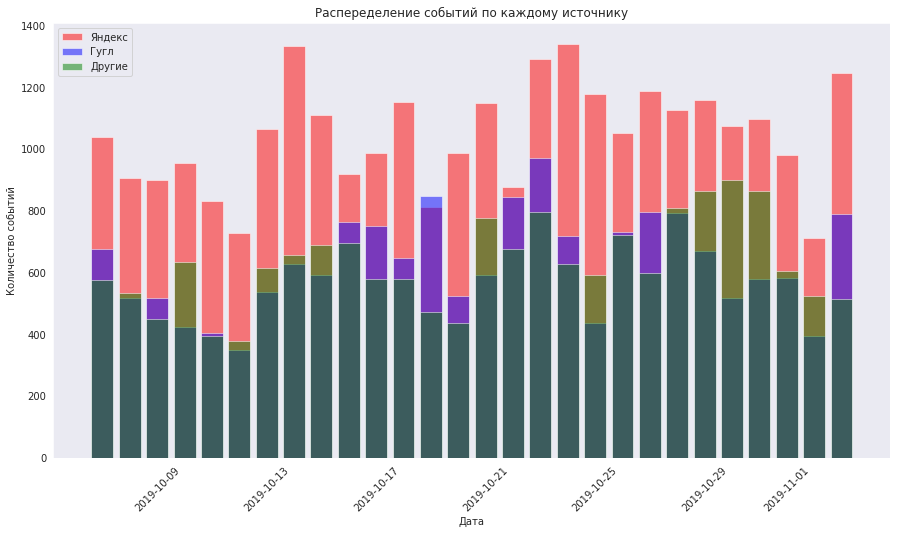

In [50]:
plt.figure(figsize=(15, 8))
with plt.style.context('seaborn-pastel'):
    plt.bar(yandex['event_date'], yandex['user_id'], alpha=.5, color=['red'])
    plt.bar(google['event_date'], google['user_id'], alpha=.5, color=['blue'])
    plt.bar(other['event_date'], other['user_id'], alpha=.5, color=['green'])
plt.title('Распеределение событий по каждому источнику')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.legend(['Яндекс', 'Гугл', 'Другие'])
plt.xticks(rotation=45)
plt.show();

- Больше всего событий совершают пользователи, пришедшие через Яндекс;
- В основном, распределение данные полностью повторяет общий график без разбивки по источникам.

#### Посчитаем продолжительность сеанса каждого пользователя в приложении.

In [51]:
# определим начало и конец каждого сеанса каждого пользователя в приложении

# начало сеанса
user_time_min = df.groupby(['user_id', 'event_date', 'event_hour'], as_index=False)\
.agg({'event_time':'min'})\
.rename(columns={'event_time':'event_time_start'})

# конец сеанса
user_time_max = df.groupby(['user_id', 'event_date', 'event_hour'], as_index=False)\
.agg({'event_time':'max'})\
.rename(columns={'event_time':'event_time_stop'})

In [52]:
# объединим столбцы с временем начала и окончания сеанса для пользователей
user_time =  pd.merge(user_time_min, user_time_max, on=['user_id', 'event_date', 'event_hour'])

In [53]:
# посчитаем, cколько длился сеанс и переведем в минуты
user_time['time_spent'] = (user_time['event_time_stop'] - user_time['event_time_start'])\
.astype('timedelta64[s]') / 60

In [54]:
# проверим
user_time.head()

,user_id,event_date,event_hour,event_time_start,event_time_stop,time_spent
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,13,2019-10-07 13:39:46,2019-10-07 13:49:42,9.93
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09,18,2019-10-09 18:33:56,2019-10-09 18:42:23,8.45
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-21,19,2019-10-21 19:52:31,2019-10-21 19:57:49,5.30
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-21,20,2019-10-21 20:00:00,2019-10-21 20:07:30,7.50
4,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-22,11,2019-10-22 11:18:15,2019-10-22 11:30:53,12.63


In [55]:
# округлим time_spent
user_time['time_spent'] = round(user_time['time_spent'], 1)

In [56]:
user_time.head()

,user_id,event_date,event_hour,event_time_start,event_time_stop,time_spent
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,13,2019-10-07 13:39:46,2019-10-07 13:49:42,9.90
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09,18,2019-10-09 18:33:56,2019-10-09 18:42:23,8.40
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-21,19,2019-10-21 19:52:31,2019-10-21 19:57:49,5.30
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-21,20,2019-10-21 20:00:00,2019-10-21 20:07:30,7.50
4,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-22,11,2019-10-22 11:18:15,2019-10-22 11:30:53,12.60


#### Сформируем таблицу с признаками для кластеризации пользователей.

In [57]:
# features - таблица с признаками\
# добавим в нее время продолжительности сеанса для каждого пользователя и \
# число сессий для каждого пользователя
features = user_time.groupby('user_id', as_index=False)\
.agg({'time_spent':'sum', 'event_date':'count'})\
.rename(columns={'event_date':'visits'})

In [58]:
features.head()

,user_id,time_spent,visits
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,43.70,5
1,00157779-810c-4498-9e05-a1e9e3cedf93,177.80,10
2,00463033-5717-4bf1-91b4-09183923b9df,21.20,2
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,87.50,7
4,00551e79-152e-4441-9cf7-565d7eb04090,9.40,3


In [59]:
# посчитаем, сколько раз пользователи совершили целевое действие - просмотр контактов
conversion = df.query('event_name=="contacts_show"')\
.groupby('user_id', as_index=False)\
.agg({'event_name':'count'})\
.rename(columns={'event_name':'conversions'})

In [60]:
conversion.head()

,user_id,conversions
0,00157779-810c-4498-9e05-a1e9e3cedf93,11
1,00551e79-152e-4441-9cf7-565d7eb04090,3
2,005fbea5-2678-406f-88a6-fbe9787e2268,3
3,00753c79-ea81-4456-acd0-a47a23ca2fb9,1
4,007d031d-5018-4e02-b7ee-72a30609173f,2


In [61]:
# добавим столбец conversions в датасет с признаками
features = pd.merge(features, conversion, on='user_id', how='left')

In [62]:
# заменим пропуски нулями
features['conversions'] = features['conversions'].fillna(0)

In [109]:
features.head()

,user_id,time_spent,visits,conversions,tips,favorites,total_time_spent,cluster_km
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,43.70,5,0.00,0.00,0.00,"21,471.10",1
1,00157779-810c-4498-9e05-a1e9e3cedf93,177.80,10,11.00,0.00,2.00,"21,337.60",1
2,00463033-5717-4bf1-91b4-09183923b9df,21.20,2,0.00,0.00,0.00,24.70,0
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,87.50,7,0.00,0.00,0.00,"18,688.20",1
4,00551e79-152e-4441-9cf7-565d7eb04090,9.40,3,3.00,0.00,0.00,"4,892.50",0


#### События tips_click и favorites_add примем за метрики вовлеченности пользователей в приложение.

In [64]:
# посчитаем, сколько раз пользователи просмотрели рекомендованные объявления и сколько раз добавили объявления в избранное

# промотр рекомендованного объявления
tips = df.query('event_name=="tips_click"')\
.groupby('user_id', as_index=False)\
.agg({'event_name':'count'})\
.rename(columns={'event_name':'tips'})

# добавление в избранное 
favorites = df.query('event_name=="favorites_add"')\
.groupby('user_id', as_index=False)\
.agg({'event_name':'count'})\
.rename(columns={'event_name':'favorites'})

In [65]:
# добавим столбцы с метриками в датасет

# просмотры
features = pd.merge(features, tips, on=['user_id'], how='left')

# добавления в избранное
features = pd.merge(features, favorites, on=['user_id'], how='left')

In [66]:
# заменим пропуски нулями
features[['tips', 'favorites']] = features[['tips', 'favorites']].fillna(0)

In [67]:
features.head()

,user_id,time_spent,visits,conversions,tips,favorites
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,43.70,5,0.00,0.00,0.00
1,00157779-810c-4498-9e05-a1e9e3cedf93,177.80,10,11.00,0.00,2.00
2,00463033-5717-4bf1-91b4-09183923b9df,21.20,2,0.00,0.00,0.00
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,87.50,7,0.00,0.00,0.00
4,00551e79-152e-4441-9cf7-565d7eb04090,9.40,3,3.00,0.00,0.00


#### Посчитаем суммарное время, проведенное каждым пользователем в приложении.

In [68]:
# определим начало и конец сеанса каждого пользователя

# начало сеанса
user_start_time = df.groupby(['user_id'], as_index=False).agg({'event_time':'min'})
user_start_time = user_start_time.rename(columns={'event_time':'user_start_time'})

# конец сеанса
user_stop_time = df.groupby(['user_id'], as_index=False).agg({'event_time':'max'})
user_stop_time = user_stop_time.rename(columns={'event_time':'user_stop_time'})

In [69]:
# объединим столбцы
total_user_time =  pd.merge(user_start_time, user_stop_time, on=['user_id'])

In [70]:
# найдем суммарное время, проведенное каждым пользователем в приложении
total_user_time['total_time_spent'] = total_user_time['user_stop_time'] - total_user_time['user_start_time']

In [71]:
# удалим ненужные столбцы 
total_user_time = total_user_time.drop(['user_start_time', 'user_stop_time'], axis=1)

In [72]:
# переведем значения в минуты
total_user_time['total_time_spent'] = total_user_time['total_time_spent'].astype('timedelta64[s]') / 60

In [73]:
# первые 5 строк
total_user_time.head()

,user_id,total_time_spent
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,"21,471.12"
1,00157779-810c-4498-9e05-a1e9e3cedf93,"21,337.60"
2,00463033-5717-4bf1-91b4-09183923b9df,24.72
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,"18,688.17"
4,00551e79-152e-4441-9cf7-565d7eb04090,"4,892.52"


In [74]:
# округлим total_time_spent
total_user_time['total_time_spent'] = round(total_user_time['total_time_spent'], 1)

In [75]:
total_user_time.head()

,user_id,total_time_spent
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,"21,471.10"
1,00157779-810c-4498-9e05-a1e9e3cedf93,"21,337.60"
2,00463033-5717-4bf1-91b4-09183923b9df,24.70
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,"18,688.20"
4,00551e79-152e-4441-9cf7-565d7eb04090,"4,892.50"


In [76]:
# добавим столбец total_time_spent в датасет с признаками
features = pd.merge(features, total_user_time, on='user_id', how='left')

In [77]:
features.head()

,user_id,time_spent,visits,conversions,tips,favorites,total_time_spent
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,43.70,5,0.00,0.00,0.00,"21,471.10"
1,00157779-810c-4498-9e05-a1e9e3cedf93,177.80,10,11.00,0.00,2.00,"21,337.60"
2,00463033-5717-4bf1-91b4-09183923b9df,21.20,2,0.00,0.00,0.00,24.70
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,87.50,7,0.00,0.00,0.00,"18,688.20"
4,00551e79-152e-4441-9cf7-565d7eb04090,9.40,3,3.00,0.00,0.00,"4,892.50"


conversions
[ 2.  5. 15.]
tips
[0. 1. 4.]
visits
[ 5.  8. 19.]
favorites
[0. 1. 9.]


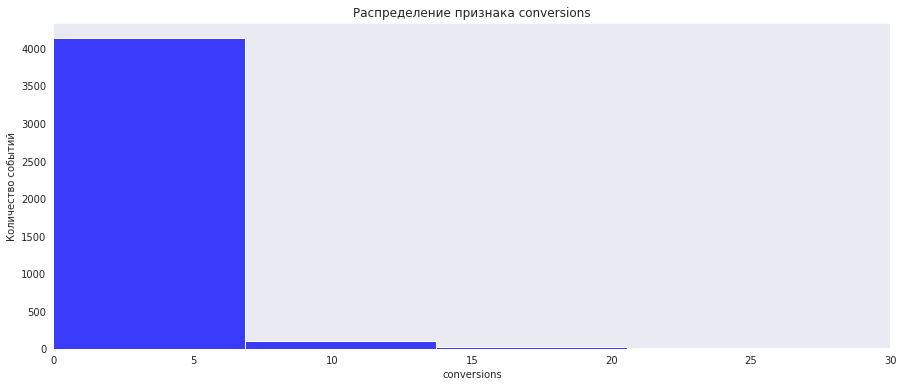

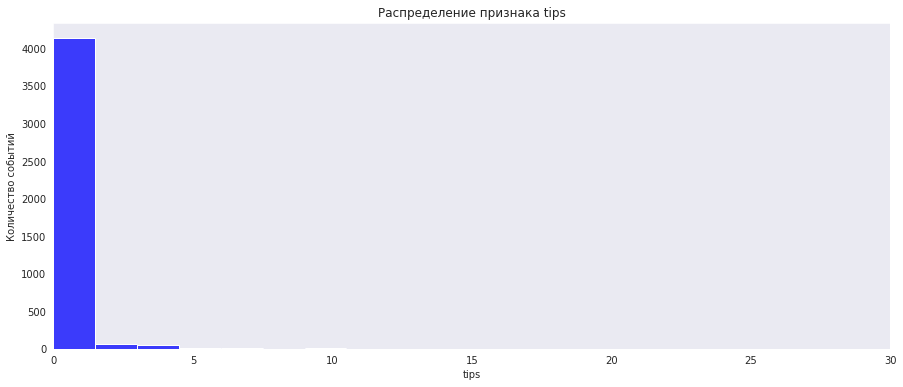

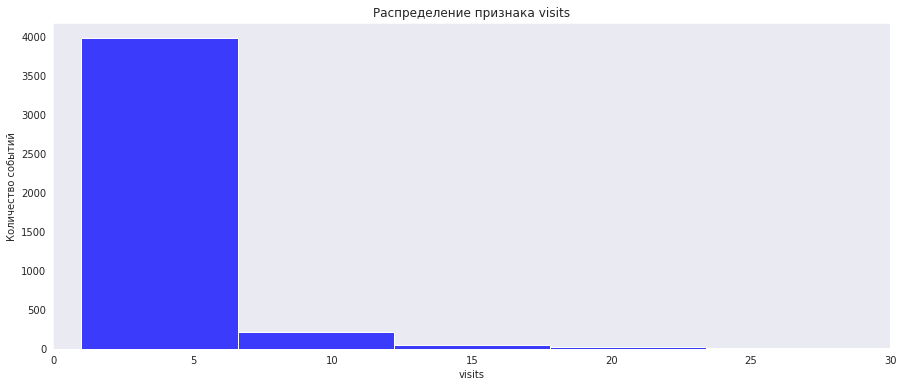

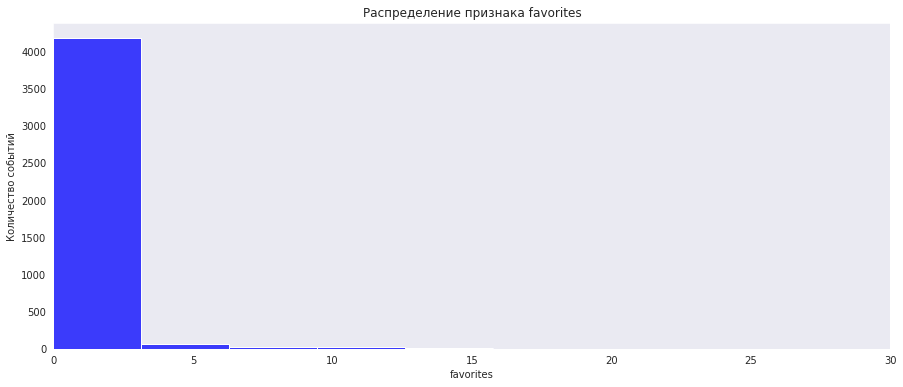

In [110]:
# нарисуем графики распределения для каждого признака
for i in {'visits', 'conversions', 'tips', 'favorites'}:
    str = 'Распределение признака '+ i
    
    plt.figure(figsize=(15, 6))
    sns.histplot(features[i], bins=20, color='blue')
    plt.title(str)
    plt.ylabel('Количество событий')
    plt.xlim(0, 30)
    plt.show
    print(i)
    print(np.percentile(features[i], [90, 95, 99]));

### Промежуточный вывод
- На каждого пользователя приходится от одной до 5 сессий;
- Пользователи крайне редко добавляют объявления в избранное;
- Пользователи крайне редко просматривают рекомендованные объявления;
- Большая часть пользователей не совершает целевое действие - просмотр контактов.

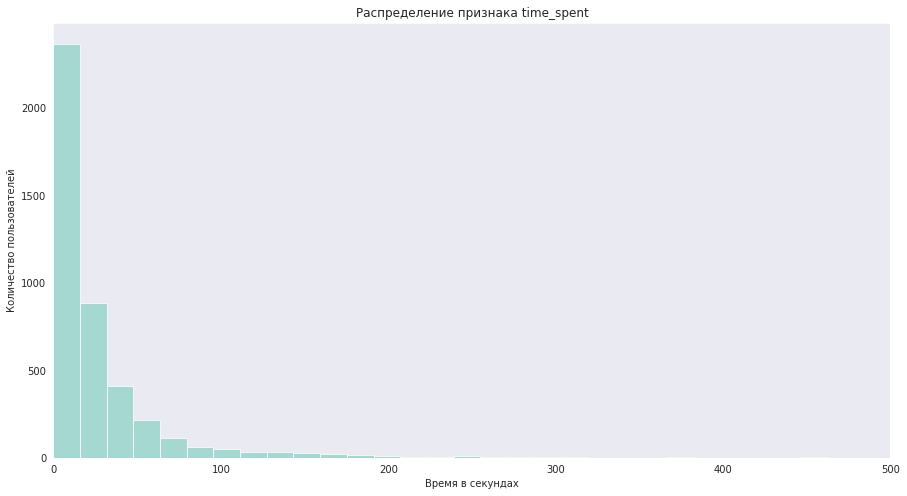

[ 62.2   102.3   241.336]


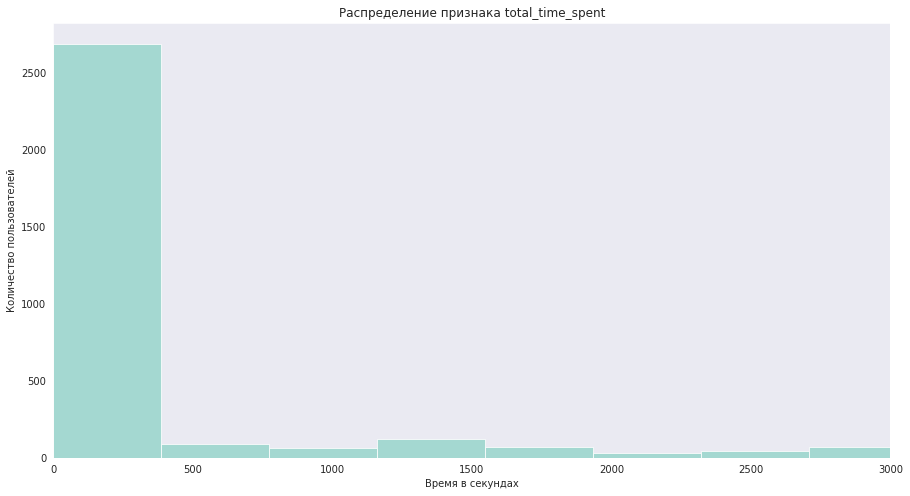

[14115.    21850.24  33106.252]


In [79]:
# нарисуем графики распределений для значений "продолжительность события" и\
# суммарное время, проведенное пользователем в приложении

# продолжительность события
plt.figure(figsize=(15, 8))
sns.histplot(features['time_spent'], bins=100)
plt.title('Распределение признака time_spent')
plt.xlabel('Время в секундах')
plt.ylabel('Количество пользователей')
plt.xlim(0, 500)
plt.show()
print(np.percentile(features['time_spent'], [90, 95, 99]))

# суммарное время пользователя в приложении
plt.figure(figsize=(15, 8))
sns.histplot(features['total_time_spent'], bins=100)
plt.title('Распределение признака total_time_spent')
plt.xlabel('Время в секундах')
plt.ylabel('Количество пользователей')
plt.xlim(0, 3000)
plt.show()
print(np.percentile(features['total_time_spent'], [90, 95, 99]));

- В основном, сеансы пользователей быстро начинаются и быстро заканчиваются. Мало какие пользователи проводят в приложении больше 100 секунд;
- Общее время, проведенное пользователем в приложении, в основном не превышает 500 секунд. Есть те, кто проводит больше времени в приложении, но их меньшинство.
- В целом, очень высок процент пользователей, которые открывают и закрывают приложение, так и не успев толком им попользоваться.

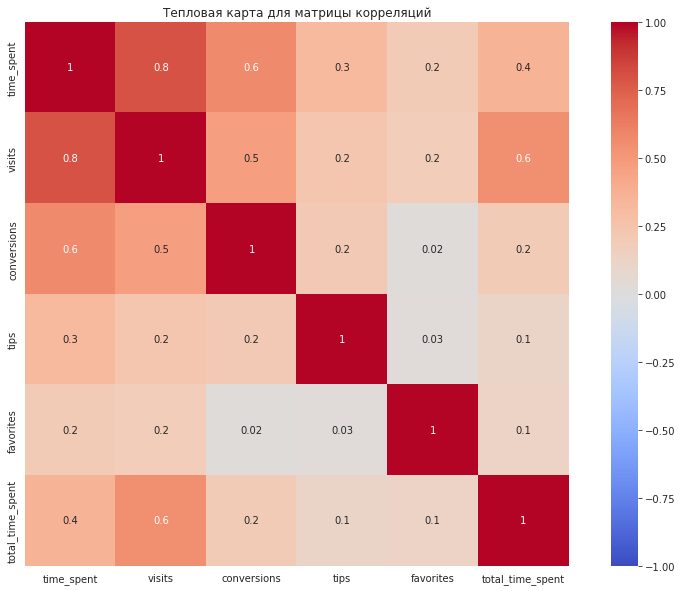

In [80]:
# матрица корреляций для таблицы с признаками
cm = features.corr() 

# нарисуем тепловую карту для матрицы корреляций
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot = True, square = True,\
            vmin = -1, vmax = 1, center = 0, fmt='.1g', cmap= 'coolwarm')
plt.title('Тепловая карта для матрицы корреляций')
plt.show();

- Сильная положительная корреляция между time_spent и visits - 0.8. Очевидно, что чем чаще пользователи посещают наше приложении, тем больше времени они в нем проводят;
- Идентичная ситуация с переменными total_time_spent и visits - 0.6;
- Выраженная положительная корреляция между time_spent и conversions - 0.6. Чем дольше длится сеанс пользователя, тем больше пользователь "вовлекается" в приложение и совершает покупку;
- Выраженная положительная корреляция между visits и conversions - 0.5. Чем чаще пользователи заходят в приложение, тем с большей вероятностью они совершают покупку.

### <a id='step4'>Кластеризация пользователей</a>

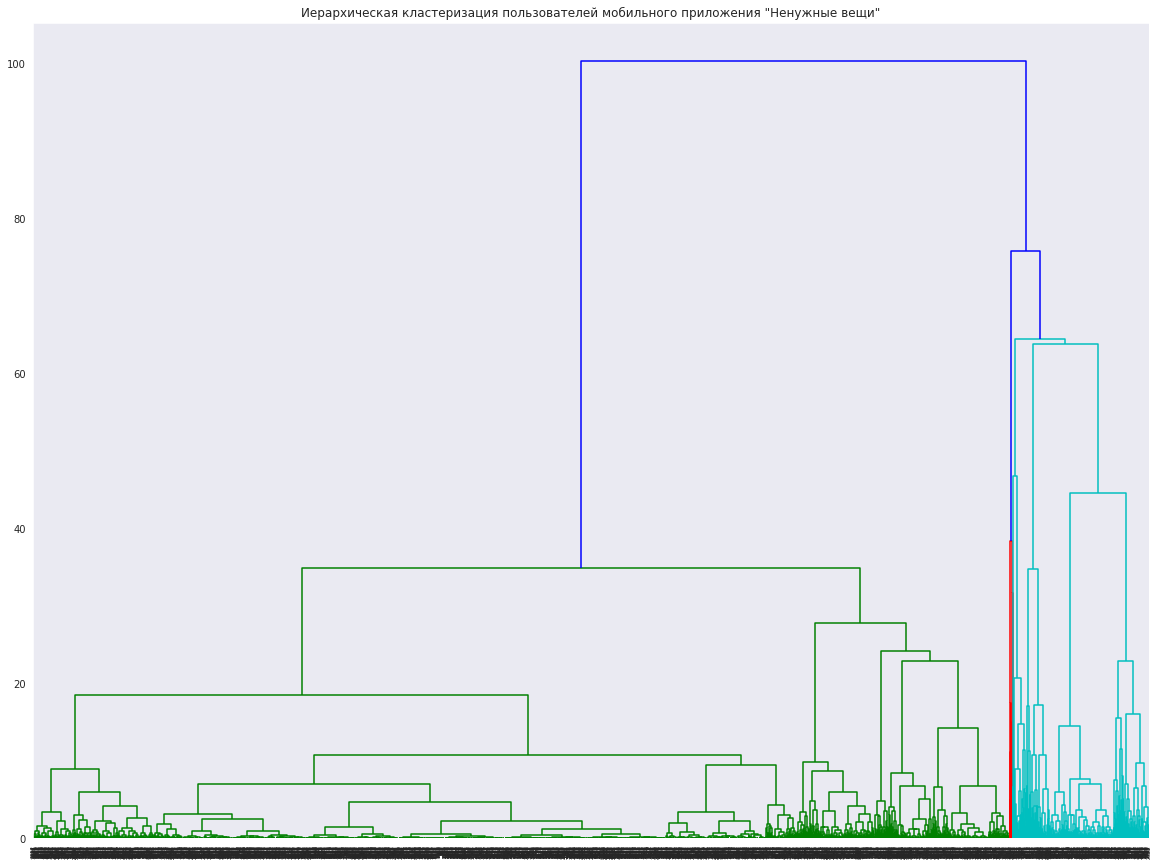

In [81]:
# построим дендограмму

# отбросим ненужный столбец с id пользователей и целевую переменную, чтобы исключить подглядывание модели
X = features.drop(['user_id', 'conversions'], axis=1)

# стандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(20, 15))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация пользователей мобильного приложения "Ненужные вещи"')
plt.show();

#### Оптимальное количество кластеров - 3.

In [82]:
# произведем кластеризацию

# обучим модель кластеризации через k-means
km = KMeans(n_clusters=3, random_state = 0)
labels = km.fit_predict(X_sc)

# сохраним кластеры в датасет с признаками
features['cluster_km'] = labels

In [83]:
# проверим. что все получилось
features.head()

,user_id,time_spent,visits,conversions,tips,favorites,total_time_spent,cluster_km
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,43.70,5,0.00,0.00,0.00,"21,471.10",1
1,00157779-810c-4498-9e05-a1e9e3cedf93,177.80,10,11.00,0.00,2.00,"21,337.60",1
2,00463033-5717-4bf1-91b4-09183923b9df,21.20,2,0.00,0.00,0.00,24.70,0
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,87.50,7,0.00,0.00,0.00,"18,688.20",1
4,00551e79-152e-4441-9cf7-565d7eb04090,9.40,3,3.00,0.00,0.00,"4,892.50",0


In [84]:
# посчитаем количество пользователей в каждом кластере
clusters_users = features.groupby('cluster_km', as_index=False)\
.count()[['cluster_km', 'user_id']]\
.rename(columns={'user_id': 'clusters_value'})

In [85]:
# посчитаем процентное соотношение
clusters_users['pies'] = round((clusters_users['clusters_value'] / features['user_id'].nunique()) * 100, 2)

In [86]:
# проверим
clusters_users.head()

,cluster_km,clusters_value,pies
0,0,3649,85.00
1,1,602,14.02
2,2,42,0.98


In [87]:
# посчитаем средние значения для признаков
clusters_mean = features.groupby('cluster_km').mean()

In [88]:
# добавим процентное соотношение
clusters_mean['pies'] = clusters_users['pies']

In [89]:
# переведем time_spent в часы
clusters_mean['time_spent'] = round(clusters_mean['time_spent'] / 60, 2)

In [90]:
# переведем total_time_spent в часы
clusters_mean['total_time_spent'] = round(clusters_mean['total_time_spent'] / 60, 2)

In [91]:
# проверим
clusters_mean.head()

,time_spent,visits,conversions,tips,favorites,total_time_spent,pies
cluster_km,,,,,,,
0,0.32,1.95,0.68,0.10,0.18,18.98,85.00
1,1.03,6.84,1.91,0.47,0.80,310.66,14.02
2,6.71,28.55,21.21,3.71,7.00,361.62,0.98


- Самым большим получился первый кластер - в него попало 85% пользователей, однако по остальным метрикам у него значения хуже остальных кластеров. Среднее время продолжительности событий - 32 минуты, а суммарное время, проведенное в приложении 19 часов. Пользователи, попавшие в первый кластер, почти не просматривают рекомендованные объявления и также не добавляют объявления в избранное. Конверсия практически на нуле - 0.68%. В среднем, на одного пользователя приходится два посещения.

---

- Во второй кластер попало 14% пользователей. По всем метрикам он лучше первого кластера, но всегда есть, куда расти. Среднее время сеанса пользователя - 62 минуты, а суммарное время, проведенное пользователями в приложении - 310 часов. Пользователи в этом кластере охотнее добавляют объявления в избранные и просматривают рекомендованные. В среднем, на одного пользователя приходится 7 посещений.

---

- В третий кластер попал 1% пользователей, однако по всем метрикам он лучше, чем два предыдущий. Среднее время сеанса составило почти 7 часов, а суммарное время, проведенное пользователями в приложении - 360 часов. Конверсия в целевое действие - просмотр контактов - 21%. Также самые высокие значения добавления объявлений в избранное и просмотр рекомендованных объявлений. Очевидно, что самые активные пользователи собрались здесь.

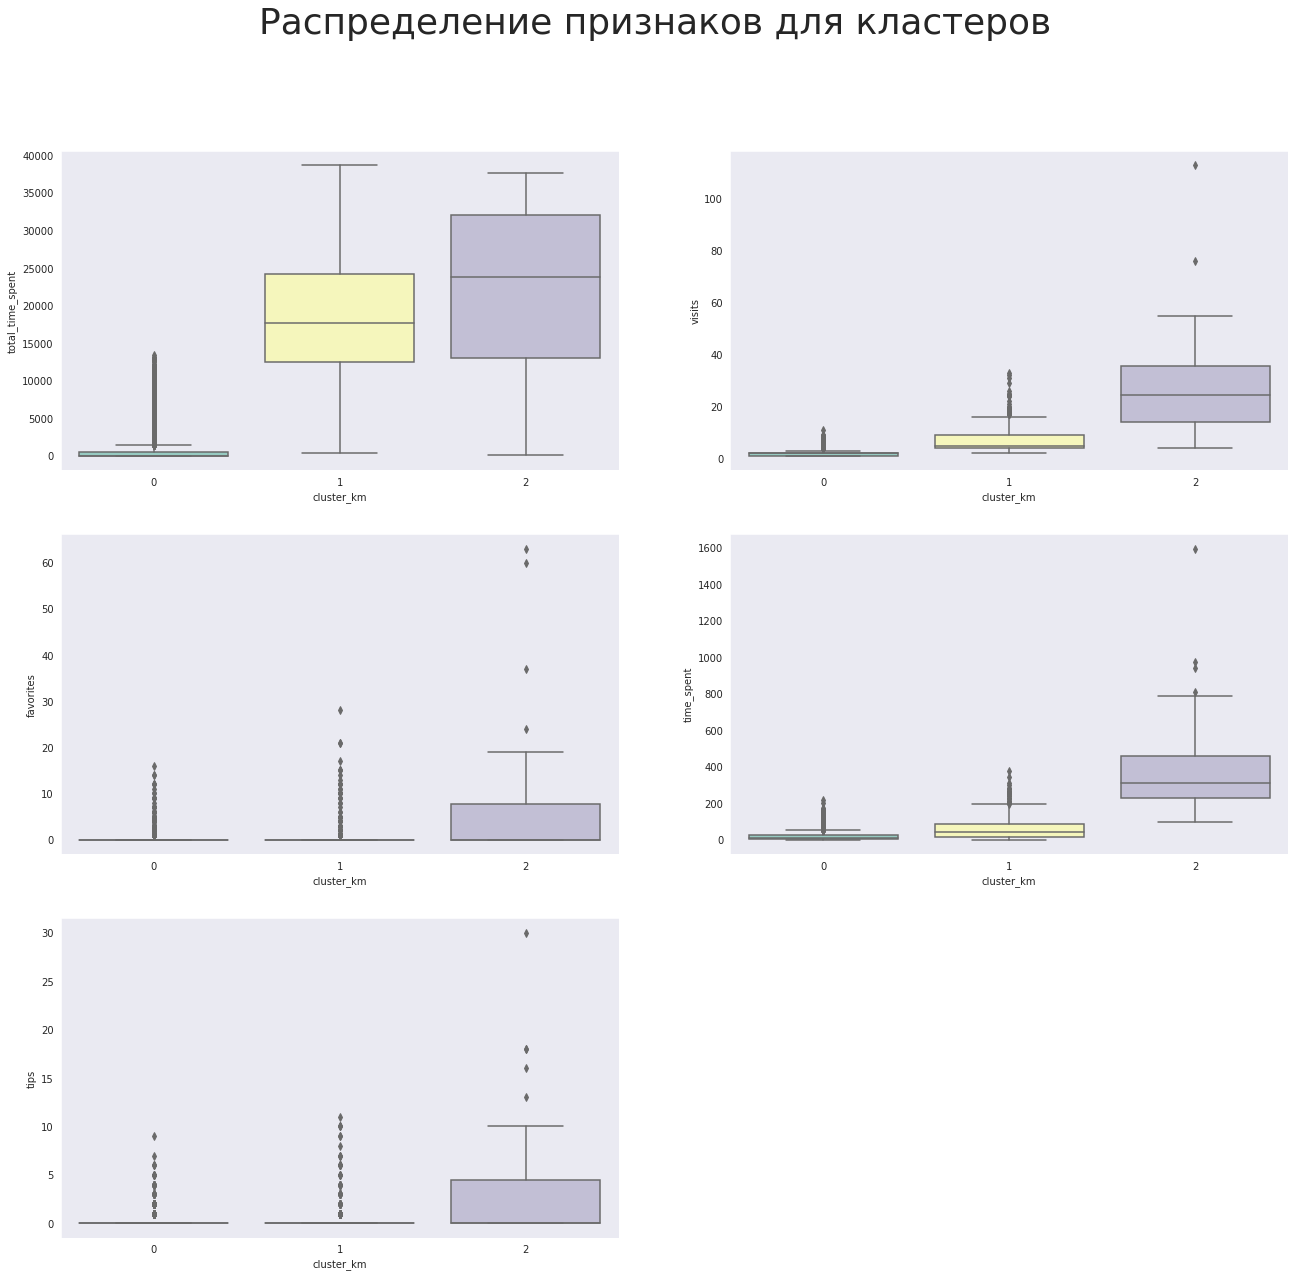

In [92]:
# нарисуем графики распределения признаков для каждого кластера
count=1
plt.subplots(figsize=(22, 20))
for column in {'visits', 'total_time_spent', 'time_spent', 'tips', 'favorites'}:
    plt.suptitle('Распределение признаков для кластеров', fontsize=36)
    plt.subplot(3, 2, count)
    sns.boxplot(x='cluster_km', y=column,  data=features)
    count+=1

plt.show();

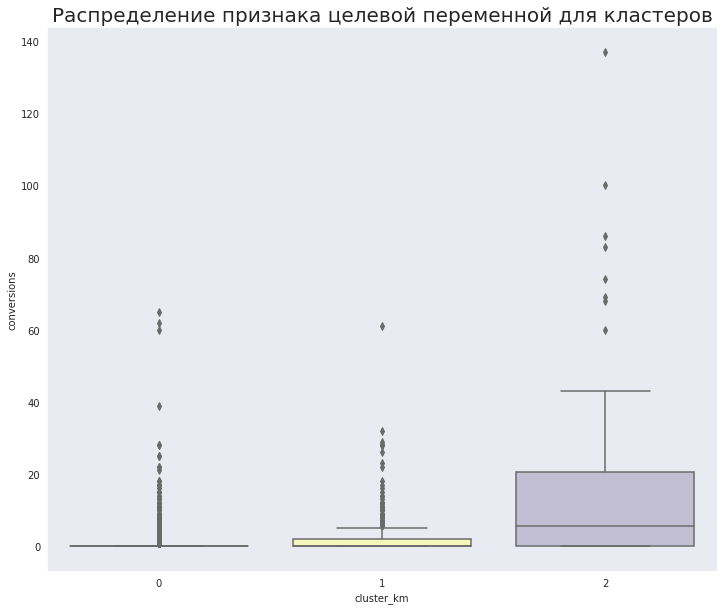

In [93]:
# нарисуем график распределения целевой переменной
plt.figure(figsize=(12, 10))
sns.boxplot(x='cluster_km', y='conversions',  data=features)
plt.title('Распределение признака целевой переменной для кластеров', fontsize=20)
plt.show();

- В целом, графики распределения признаков подтверждают ранее сделанные выводы.

In [94]:
sources

,user_id,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google
...,...,...
4288,b86fe56e-f2de-4f8a-b192-cd89a37ecd41,yandex
4289,424c0ae1-3ea3-4f1e-a814-6bac73e48ab1,yandex
4290,437a4cd4-9ba9-457f-8614-d142bc48fbeb,yandex
4291,c10055f0-0b47-477a-869e-d391b31fdf8f,yandex


### <a id='step5'>Проверка статистических гипотез</a>

In [95]:
# сформируем таблицу с общим количеством пользователей по источникам
total_users = sources.groupby('source', as_index=False)\
.count()\
.rename(columns={'user_id':'total_users'})

In [96]:
total_users.head()

,source,total_users
0,google,1129
1,other,1230
2,yandex,1934


In [97]:
sources.head()

,user_id,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


In [98]:
data

,event_time,event_name,user_id
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c
...,...,...,...
74192,2019-11-03 23:53:30,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9
74193,2019-11-03 23:54:00,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9
74194,2019-11-03 23:56:57,search_1,20850c8f-4135-4059-b13b-198d3ac59902
74195,2019-11-03 23:57:06,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9


In [99]:
# сформируем таблицу с пользователями, совершившими целевое действие - просмотр контактов
goal_users = df.query('event_name=="contacts_show"')\
.groupby(['source'], as_index=False)\
.agg({'user_id':'nunique'})\
.rename(columns={'user_id':'goal_users'})

In [100]:
# объединим датасеты
conversion_users = pd.merge(goal_users, total_users, on='source')

In [101]:
# рассчиатем CR
conversion_users['cr'] = round(conversion_users['goal_users'] / conversion_users['total_users'], 2)

In [102]:
# проверим
conversion_users

,source,goal_users,total_users,cr
0,google,275,1129,0.24
1,other,228,1230,0.19
2,yandex,478,1934,0.25


In [103]:
# сформируем таблицу с пользователями, добавившими объявление в избранное
fav_users = df.query('event_name=="favorites_add"')\
.groupby(['source'], as_index=False).agg({'user_id':'nunique'})\
.rename(columns={'user_id':'favorites_users'})

In [104]:
# объединим датасеты
fav_users_1 = pd.merge(fav_users, total_users, on='source')

In [105]:
# рассчитаем CR
fav_users_1['cr'] = round(fav_users_1['favorites_users'] / fav_users_1['total_users']*100, 2)

In [106]:
# проверим
fav_users_1

,source,favorites_users,total_users,cr
0,google,114,1129,10.10
1,other,77,1230,6.26
2,yandex,160,1934,8.27


#### Проведем проверку первый пары статистических гипотез.

#### H0 - Конверсия в просмотр контактов между пользователями, установшими приложение по ссылке из yandex и пользователями, установшими приложение по ссылке из google, одинаковая;
#### H1 - Конверсия в просмотр контактов между пользователями, установившими приложение по ссылке из yandex и пользователями, установившими приложение по ссылке из google, различается.

In [107]:
alpha = .05 # критический уровень статистической значимости

purchases = np.array([275, 478])
leads = np.array([1129, 1934])

p1 = purchases[0] / leads[0]
p2 = purchases[1] / leads[1]
p_combined = (purchases[0] + purchases[1]) / (leads[0] + leads[1])
z_value = (p1 - p2) / mth.sqrt(p_combined * (1 - p_combined) * (1/leads[0] + 1/leads[1]))
distr = stats.norm(0, 1)
p_value = (1 - distr.cdf(abs(z_value))) * 2
print('z_value =', z_value)

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

z_value = -0.2218487822311678
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Проведем проверку второй пары статистических гипотез.

#### H0 - Конверсия в добавление объявления в избранное между пользователями, установившими приложение по ссылке из yandex не отличается от конверсии пользователей, установивших приложение по ссылке из google;
#### H1 - Конверсия в добавление объявления в избранное между пользователями, установшими приложение по ссылке из yandex отличается от конверсии пользователей, установивших приложение по ссылке из google.

In [108]:
alpha = .05 # критический уровень статистической значимости

purchases = np.array([114, 160])
leads = np.array([1129, 1934])

p1 = purchases[0] / leads[0]
p2 = purchases[1] / leads[1]
p_combined = (purchases[0] + purchases[1]) / (leads[0] + leads[1])
z_value = (p1 - p2) / mth.sqrt(p_combined * (1 - p_combined) * (1/leads[0] + 1/leads[1]))
distr = stats.norm(0, 1)
p_value = (1 - distr.cdf(abs(z_value))) * 2
print('z_value =', z_value)

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

z_value = 1.7067679449703979
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


- Разницы в конверсии в просмотр контактов между пользователями, пришедшими из yandex и пользователями, пришедшими из google, нет. Не отвергаем нулевую гипотезу;
- Разницы в конверсии в добавлении объявления в избранноое между пользователями, пришедшими из yandex и пользователями, пришедшими из google, нет. Не отвергаем нулевое гипотезу.
- Обе нулевые гипотезы подтверждены.

### <a id='step6'>Общий вывод и рекомендации</a>

- Приложением в период исследования воспользовалось 4239 пользователя;
- Больше трафика приходит через Яндекс 1934, а меньше всего через Google - 1129 пользователей;
- Наибольшая активность в будние дни;
- Конверсия в целовое действие - просмотр контактов - 23%.

---

#### Пользователи разделены на три кластера:

#### Кластер 1 
- 85% всех пользователей. Среднее время продолжительности пользовательского сеанса - 32 минуты. Суммарное время, проведенное в приложении - 19 часов. Пользователи редко просматривают рекомендованные объявления и не добавляют объявления в избранное. Конверсия в целевое действие - 68%. На одного пользователя приходится 2 посещения.

---

#### Кластер 2
- 14% всех пользователей. Среднее время сеанса - 62 минуты. Суммарное время, проведенное в приложении - 310 часов. Пользователи охотнее добавляют объявления в избранное и просматривают рекомендованные объявления. На одного пользователся приходится 7 посещений.

---

#### Кластер 3
- 1% пользователей. Среднее время сеанса - 7 часов. Суммарное время, проведенное в приложении - 360 часов. Эти пользователи активнее всех добавляют объявления в избранное и просматривают рекомендованные объявления. Самая высокая конверсия в целевое действие - 21 %. Наши лучшие пользователи!

---

#### В процессе исследования проверены две пары статистчиских гипотез:

#### H0 - Конверсия в просмотр контактов между пользователями, установшими приложение по ссылке из yandex и пользователями, установшими приложение по ссылке из google, одинаковая;
#### H1 - Конверсия в просмотр контактов между пользователями, установившими приложение по ссылке из yandex и пользователями, установившими приложение по ссылке из google, различается.

---

#### H0 - Конверсия в добавление объявления в избранное между пользователями, установившими приложение по ссылке из yandex не отличается от конверсии пользователей, установивших приложение по ссылке из google;
#### H1 - Конверсия в добавление объявления в избранное между пользователями, установшими приложение по ссылке из yandex отличается от конверсии пользователей, установивших приложение по ссылке из google.

---

#### Исходя из результатов статистической проверки гипотез, можно сделать вывод, что между долями в конверсии отсутствует статистически значимая разница, следовательно, обе гипотезы H0 подтверждены. Разницы в конверсии в просмотр контактов между пользователями, пришедшими из yandex и пользователями, пришедшими из google, нет. Разницы в конверсии в добавлении объявления в избранноое между пользователями, пришедшими из yandex и пользователями, пришедшими из google, нет.

---

#### Рекомендации для привлечения и увеличения показателя вовлеченности пользователей в мобильном приложении "Ненужные вещи".
- Необходимо развивать маркетинговые активности не только в Яндекс, но в Google и в других источниках. Хорошо, конечно, что Яндекс приводит столько пользователей, но желательно диверсифицировать каналы. Особенно стоит изучить канал other, через него приходит много пользователей, а мы даже, незнаем, что это за источники;
- Усовершенствовать алгоритм подбора рекомендованных объявлений. Вполне вероятно, что сейчас пользователи не просматриват рекомендованные объявления и не добавляют объявления в избранное из-за того, что алгоритмы предлагают нерелеванты объявления;
- Для увеличения количества покупок можно ввести систему доставки, чтобы пользователи могли совершать покупки на всей территории страны, как это сейчас реализовано в Авито.